In [1]:
import tensorflow as tf
import keras as K
import keras.backend as kb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

/home/dungeon_master/.conda/envs/downloader/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
df = pd.read_csv("datasets/criminal_train.csv")

#split in test and train
train_X,test_X,train_Y,test_Y = train_test_split(df.drop(['Criminal'],axis=1),
                                                 df['Criminal'], test_size = 0.15)

Text(0.5,0,'0    6337\n1     521\nName: Criminal, dtype: int64')

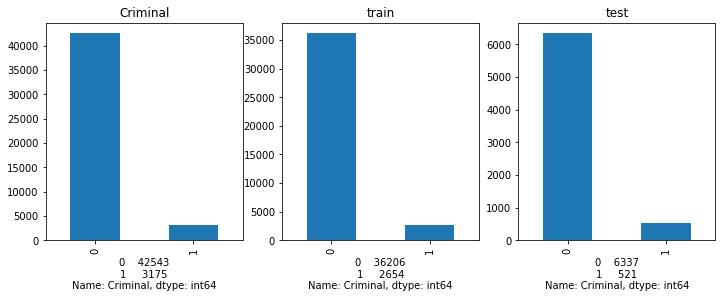

In [3]:
#before oversampling
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

df['Criminal'].value_counts().plot(ax=axes[0],kind='bar', title='Criminal').set_xlabel(df['Criminal'].value_counts())
train_Y[:].value_counts().plot(ax=axes[1],kind='bar',title ='train').set_xlabel(train_Y[:].value_counts())
test_Y[:].value_counts().plot(ax=axes[2],kind='bar',title ='test').set_xlabel(test_Y[:].value_counts())



In [4]:
#create validation set
#train_Y = pd.DataFrame(train_Y.values,columns=['Criminal'])

train_X,val_X,train_Y,val_Y = train_test_split(train_X,train_Y, test_size = 0.15)


Text(0.5,0,'0    5430\n1     399\nName: Criminal, dtype: int64')

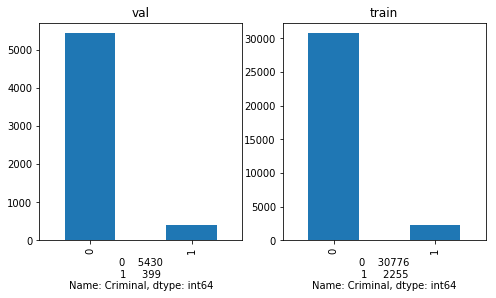

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
train_Y[:].value_counts().plot(ax=axes[1],kind='bar',title ='train').set_xlabel(train_Y[:].value_counts())
val_Y[:].value_counts().plot(ax=axes[0],kind='bar',title ='val').set_xlabel(val_Y[:].value_counts())

In [6]:
print(train_X.shape,train_Y.shape,val_X.shape,val_Y.shape)
train_Y = train_Y.reshape(-1,1)
print(train_Y.shape)

(33031, 71) (33031,) (5829, 71) (5829,)
(33031, 1)


/home/dungeon_master/.conda/envs/downloader/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [7]:
#oversampling
sm = SMOTE(ratio = 1)
train_X,train_Y = sm.fit_sample(train_X,train_Y)

/home/dungeon_master/.conda/envs/downloader/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dungeon_master/.conda/envs/downloader/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
bins,counts = np.unique(train_Y,return_counts=True)
print(train_X.shape,train_Y.shape)
print(np.asarray((bins, counts)).T)

(61552, 71) (61552,)
[[    0 30776]
 [    1 30776]]


In [9]:
train_X = train_X[:,1:]
train_Y = train_Y.reshape(-1,1)
print(train_X.shape)

(61552, 70)


In [10]:
def finalmodel(input_shape):
    
    X_input = K.layers.Input(input_shape)
    X = X_input
    
    X = K.layers.Dropout(0.2)(X)
    X = K.layers.Dense(units = 25, activation = 'relu', kernel_initializer = 'random_uniform', bias_initializer ='zeros')(X)
                          #,kernel_regularizer = K.regularizers.l2(0.01))(X)
    X = K.layers.Dropout(0.2)(X)
    
    X = K.layers.Dense(units = 10, activation = 'relu', kernel_initializer = 'random_uniform', bias_initializer ='zeros')(X)
                         # ,kernel_regularizer = K.regularizers.l2(0.01))(X)
    X = K.layers.Dropout(0.2)(X)
    
    X = K.layers.Dense(units = 1, activation = 'sigmoid',kernel_initializer = 'random_uniform', bias_initializer = 'zeros')(X)
                         # ,kernel_regularizer = K.regularizers.l2(0.01))(X)
    
    model = K.models.Model(inputs = X_input, outputs = X, name = "finalmodel");
    
    return model

In [11]:
def matthews_correlation(y_true, y_pred):
    y_pred_pos = kb.round(kb.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = kb.round(kb.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = kb.sum(y_pos * y_pred_pos)
    tn = kb.sum(y_neg * y_pred_neg)

    fp = kb.sum(y_neg * y_pred_pos)
    fn = kb.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = kb.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + kb.epsilon())

In [12]:
#print(np.unique(train_Y).shape)
#class_weight = class_weight.compute_class_weight('balanced', np.unique(train_Y), train_Y.reshape(train_Y.shape[0]))
#print(class_weight)

In [13]:
final_model = finalmodel((70,))

adam = K.optimizers.adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
#sgd  = K.optimizers.sgd(lr=0.0001,decay=1e-6)
final_model.compile(optimizer='adam',loss= K.losses.mean_squared_logarithmic_error,metrics=[matthews_correlation])

In [14]:
print(np.unique(train_Y))

tbCallback = K.callbacks.TensorBoard(log_dir="./logs", histogram_freq=0, batch_size=1024, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

final_model.fit(train_X,train_Y,epochs = 240,batch_size=1024,callbacks=[tbCallback])

[0 1]
Epoch 1/240
61552/61552 [==============================] - 1s 9us/step - loss: 0.8928 - matthews_correlation: 0.0027
Epoch 2/240
61552/61552 [==============================] - 0s 8us/step - loss: 0.6934 - matthews_correlation: 0.0151
Epoch 3/240
61552/61552 [==============================] - 0s 7us/step - loss: 0.6932 - matthews_correlation: 0.0127
Epoch 4/240
61552/61552 [==============================] - 0s 7us/step - loss: 0.6932 - matthews_correlation: 0.0171
Epoch 5/240
61552/61552 [==============================] - 0s 6us/step - loss: 0.6933 - matthews_correlation: 0.0163
Epoch 6/240
61552/61552 [==============================] - 1s 12us/step - loss: 0.6930 - matthews_correlation: 0.0272
Epoch 7/240
61552/61552 [==============================] - 1s 8us/step - loss: 0.6930 - matthews_correlation: 0.0282
Epoch 8/240
61552/61552 [==============================] - 0s 6us/step - loss: 0.6925 - matthews_correlation: 0.0592
Epoch 9/240
61552/61552 [==============================] 

61552/61552 [==============================] - 0s 7us/step - loss: 0.5094 - matthews_correlation: 0.5024
Epoch 70/240
61552/61552 [==============================] - 1s 8us/step - loss: 0.5136 - matthews_correlation: 0.4973
Epoch 71/240
61552/61552 [==============================] - 0s 7us/step - loss: 0.5102 - matthews_correlation: 0.4984
Epoch 72/240
61552/61552 [==============================] - 0s 7us/step - loss: 0.5174 - matthews_correlation: 0.4849
Epoch 73/240
61552/61552 [==============================] - 0s 7us/step - loss: 0.5206 - matthews_correlation: 0.4751
Epoch 74/240
61552/61552 [==============================] - 0s 7us/step - loss: 0.5118 - matthews_correlation: 0.4957
Epoch 75/240
61552/61552 [==============================] - 0s 7us/step - loss: 0.5154 - matthews_correlation: 0.4891
Epoch 76/240
61552/61552 [==============================] - 0s 6us/step - loss: 0.5176 - matthews_correlation: 0.4823
Epoch 77/240
61552/61552 [==============================] - 0s 7us/st

61552/61552 [==============================] - 0s 7us/step - loss: 0.4976 - matthews_correlation: 0.5419
Epoch 139/240
61552/61552 [==============================] - 0s 6us/step - loss: 0.5077 - matthews_correlation: 0.5283
Epoch 140/240
61552/61552 [==============================] - 0s 6us/step - loss: 0.5021 - matthews_correlation: 0.5339
Epoch 141/240
61552/61552 [==============================] - 0s 7us/step - loss: 0.4971 - matthews_correlation: 0.5428
Epoch 142/240
61552/61552 [==============================] - 0s 6us/step - loss: 0.5015 - matthews_correlation: 0.5359
Epoch 143/240
61552/61552 [==============================] - 0s 7us/step - loss: 0.4980 - matthews_correlation: 0.5433
Epoch 144/240
61552/61552 [==============================] - 0s 7us/step - loss: 0.4992 - matthews_correlation: 0.5397
Epoch 145/240
61552/61552 [==============================] - 1s 8us/step - loss: 0.4994 - matthews_correlation: 0.5377
Epoch 146/240
61552/61552 [==============================] - 0

Epoch 207/240
61552/61552 [==============================] - 0s 7us/step - loss: 0.4891 - matthews_correlation: 0.5564
Epoch 208/240
61552/61552 [==============================] - 0s 7us/step - loss: 0.4827 - matthews_correlation: 0.5626
Epoch 209/240
61552/61552 [==============================] - 0s 7us/step - loss: 0.4761 - matthews_correlation: 0.5713
Epoch 210/240
61552/61552 [==============================] - 0s 8us/step - loss: 0.4859 - matthews_correlation: 0.5624
Epoch 211/240
61552/61552 [==============================] - 0s 6us/step - loss: 0.4855 - matthews_correlation: 0.5631
Epoch 212/240
61552/61552 [==============================] - 0s 7us/step - loss: 0.4801 - matthews_correlation: 0.5692
Epoch 213/240
61552/61552 [==============================] - 0s 8us/step - loss: 0.4907 - matthews_correlation: 0.5564
Epoch 214/240
61552/61552 [==============================] - 0s 8us/step - loss: 0.4800 - matthews_correlation: 0.5705
Epoch 215/240
61552/61552 [=====================

In [15]:
print(final_model.metrics_names[1])

matthews_correlation


In [16]:
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 70)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1775      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                260       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total para

In [17]:
# print(val_X[val_X.columns[0:4]])
# #print(val_X.shape)
# perid = test_X[test_X.columns[0:1]];
# val_X = val_X[val_X.columns[1:71]]
# print(val_X.shape,val_Y.shape)
# test_X = test_X[test_X.columns[1:71]];

In [18]:
perid = test_X[test_X.columns[0:1]];
temp_val_X = val_X[val_X.columns[1:]]
print(test_X.shape,val_Y.shape)
temp_test_X = test_X[test_X.columns[1:]]
print(temp_test_X.shape,val_Y.shape)

(6858, 71) (5829,)
(6858, 70) (5829,)


In [19]:
final_model.evaluate(x=temp_val_X,y=val_Y)

5829/5829 [==============================] - 0s 40us/step


[0.35284055678180609, 0.40396976066016071]

In [20]:

test_Y = test_Y.reshape(-1,1)
print(test_X.shape,test_Y.shape)


(6858, 71) (6858, 1)


/home/dungeon_master/.conda/envs/downloader/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [21]:
final_model.evaluate(x=temp_test_X,y=test_Y)

6858/6858 [==============================] - 0s 40us/step


[0.37336773604163276, 0.40095623751429227]

In [22]:
test_X.iloc[0].shape

(71,)

In [23]:
final_model.predict(x=temp_test_X)

array([[  6.83998764e-01],
       [  6.38839370e-03],
       [  1.27115458e-01],
       ..., 
       [  3.80376279e-01],
       [  3.95530988e-05],
       [  1.46444468e-03]], dtype=float32)

In [24]:
df = pd.read_csv("datasets/criminal_test.csv")

In [25]:
perid = df[df.columns[:1]]
final_test_X = df[df.columns[1:]] 
print(final_test_X.shape)

(11430, 70)


In [26]:
output  = final_model.predict(x=final_test_X)
output = [1 if x>0.8 else 0 for x in output]
output = pd.DataFrame(output,columns=["Criminal"])
answer = pd.concat([perid,output],axis=1)
answer.to_csv("out.csv",index=False)